TokaMax Example: Pulse design example in ITER {#doc_tMax_ITER_ex1}
==========
In this example we show how to use TokaMax for a simple pulse in ITER.
Note: this example requires torax to be installed.

In [1]:
import os
import sys
import json
import numpy as np
import matplotlib.pyplot as plt
import torax

plt.rcParams['figure.figsize']=(6,6)
plt.rcParams['font.weight']='bold'
plt.rcParams['axes.labelweight']='bold'
plt.rcParams['lines.linewidth']=2
plt.rcParams['lines.markeredgewidth']=2
%matplotlib inline
%config InlineBackend.figure_format = "retina"

15:31:28 CRITICAL Could not import 'imas_core': No module named 'imas_core'. Some functionality is not available. @imas_interface.py:34


## Load TokaMaker library

In [2]:
tokamaker_python_path = os.getenv('OFT_ROOTPATH')
if tokamaker_python_path is not None:
    sys.path.append(os.path.join(tokamaker_python_path,'python'))
from OpenFUSIONToolkit.TokaMax import TokaMax

## Load EQDSK files

Choose EQDSK files that represent specific time points including ramp-up, flat-top, and ramp-down equilibria for the pulse.

In [3]:
# Set timesteps
rampup_times = np.linspace(5.0, 80.0, 10)
flattop_times = np.linspace(100.0, 450.0, 10)
rampdown_times = np.linspace(500.0, 600.0, 10)
times = np.r_[rampup_times, flattop_times, rampdown_times]

# Load gEQDSK
g_arr_rampup = [f'ITER-eqdsk/rampup_i={i}.eqdsk' for i in range(10)]
g_arr_flattop = ['ITER-eqdsk/Hmode.eqdsk'] * 10
g_arr_rampdown = g_arr_rampup[::-1]
g_arr = np.r_[g_arr_rampup, g_arr_flattop, g_arr_rampdown]


## Create TokaMax solver object

Creates the TokaMax solver object with simulation running from t=0s to t=600s. Results will be saved at 10s intervals between 0s and 600s. Set coil targets to zero (weakly weighted) so the solver will try to find the lowest possible currents to reproduce the given equilibria. Here we are using a mesh generated from the TokaMaker example notebooks.

In [4]:
t_res = np.arange(0.0, 600.0, 10.0)
mysim = TokaMax(0.0, 600.0, times, g_arr, t_res=t_res, last_surface_factor=0.9)
mysim.initialize_gs('ITER_mesh.h5', vsc='VS')

coils = ['CS3U', 'CS2U', 'CS1U', 'CS1L', 'CS2L', 'CS3L', 'PF1', 'PF2', 'PF3', 'PF4', 'PF5', 'PF6']
coil_targets = {coil_name: 0.0 for coil_name in coils}
mysim.set_coil_reg(coil_targets, strict_limit=1.0E8)


#----------------------------------------------
Open FUSION Toolkit Initialized
Development branch:   Add-TokaMax
Revision id:          79a729e
Parallelization Info:
  Not compiled with MPI
  # of OpenMP threads =    2
Fortran input file    = /var/folders/qz/wcp9q1mj0c5fsyjtbt99bvhh0000gn/T/oft_24409/oftpyin
XML input file        = none
Integer Precisions    =    4   8
Float Precisions      =    4   8  16
Complex Precisions    =    4   8
LA backend            = native
#----------------------------------------------


**** Loading OFT surface mesh

**** Generating surface grid level  1
  Generating boundary domain linkage
  Mesh statistics:
    Area         =  2.859E+02
    # of points  =    4757
    # of edges   =   14156
    # of cells   =    9400
    # of boundary points =     112
    # of boundary edges  =     112
    # of boundary cells  =     112
  Resolution statistics:
    hmin =  9.924E-03
    hrms =  2.826E-01
    hmax =  8.466E-01
  Surface grounded at vertex     870


**** C

## Set Actuators and Boundary Conditions

Set the plasma current, ECCD and NBI heating, pedestals, and boundary conditions. Also sets the line-averaged density and effective plasma charge.

In [5]:
# Set current
ip = {0: 3.0E6, 5: 3.0E6, 80: 15.0E6, 500: 15.0E6, 590: 4.0E6, 600: 4.0E6}

# Set heating
powers = {0: 0, 24: 0, 25: 10.0E6, 79: 10.0E6, 80: 52.0E6, 124: 52.0E6, 125: 40.0E6, 500: 40.0E6, 524: 40.0E6, 525: 35.0E6, 549: 35.0E6, 550: 30.0E6}
nbi_powers = {k: 0.5 * v for k, v in powers.items()}
eccd_powers = {k: 0.5 * v for k, v in powers.items()}

# Set pedestals
T_i_ped = {0: 0.146, 80: 0.146, 85: 3.69, 500: 3.69, 505: 0.146}
T_e_ped = {0: 0.220, 80: 0.220, 85: 3.69, 500: 3.69, 505: 0.220}
n_e_ped = {0: 1.821E19, 79: 1.821E19, 80: 7.482E19}

# Set boundary conditions
ne_right_bc = {0: 0.157E20, 79: 0.157E20, 80: 0.414E20}
Te_right_bc = 0.01
Ti_right_bc = 0.01

mysim.set_Ip(ip)
mysim.set_Zeff(1.8)
mysim.set_heating(nbi=nbi_powers, nbi_loc=0.25, eccd=eccd_powers, eccd_loc=0.35)
mysim.set_right_bc(Te_right_bc=Te_right_bc, Ti_right_bc=Ti_right_bc, ne_right_bc=ne_right_bc)
mysim.set_pedestal(T_i_ped=T_i_ped, T_e_ped=T_e_ped, n_e_ped=n_e_ped)
mysim.set_nbar({0: 0.326E20, 80: .905E20})

## Run Sim

Run the simulation for five iterations. The `remove_tmp` keyword argument suppresses user input, which is normally requested to confirm that the user would like to delete previous simulation data. The `graph` argument can be set to `True` if the user would like to see graphs of the plasma equilibria while the simulation is running.

In [6]:
mysim.fly(max_step=5, remove_tmp=True, graph=False)

INFO:2025-11-13 15:31:30,062:jax._src.xla_bridge:808: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/opt/homebrew/anaconda3/bin/../lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file)
2025-11-13 15:31:30,062 [    INFO] Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/opt/homebrew/anaconda3/bin/../lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file)
2025-11-13 15:31:30,092 [ WARNING] 
               The TORAX EQDSK converter has only been tested against CHEASE-generated EQDSK which is COCOS=2.
               The converter is not guaranteed to work as expected with arbi

Starting non-linear GS solver
     1  2.6145E+00  2.6462E-03  1.1622E-01  6.7125E+00  4.7131E-01  2.7029E-10
     2  2.6717E+00  2.7103E-03  7.0345E-02  6.6991E+00  4.8701E-01  1.3666E-10
     3  2.6868E+00  2.7274E-03  3.2105E-02  6.6946E+00  4.9426E-01  1.5784E-10
     4  2.6911E+00  2.7325E-03  1.2878E-02  6.6931E+00  4.9753E-01  1.7943E-10
     5  2.6924E+00  2.7340E-03  4.9642E-03  6.6925E+00  4.9896E-01  1.5710E-10
     6  2.6928E+00  2.7345E-03  1.8931E-03  6.6923E+00  4.9958E-01  1.5698E-10
     7  2.6929E+00  2.7346E-03  7.2069E-04  6.6923E+00  4.9984E-01  1.5693E-10
     8  2.6929E+00  2.7347E-03  2.7701E-04  6.6922E+00  4.9995E-01  1.5691E-10
     9  2.6929E+00  2.7347E-03  1.0786E-04  6.6922E+00  5.0000E-01  1.5690E-10
    10  2.6929E+00  2.7347E-03  4.2503E-05  6.6922E+00  5.0002E-01  1.5690E-10
    11  2.6929E+00  2.7347E-03  1.6900E-05  6.6922E+00  5.0002E-01  1.5690E-10
    12  2.6929E+00  2.7347E-03  6.7679E-06  6.6922E+00  5.0003E-01  1.5690E-10
    13  2.6929E+00  2.

 Using COCOS=2...
Starting non-linear GS solver
     1  2.1356E+00  1.9086E-02  1.6379E-01  6.7612E+00  4.7154E-01 -1.4011E-03
     2  2.1889E+00  1.9545E-02  1.0395E-01  6.7620E+00  4.8731E-01  2.9925E-03
     3  2.2027E+00  1.9664E-02  4.7381E-02  6.7625E+00  4.9457E-01  4.4102E-03
     4  2.2067E+00  1.9699E-02  1.8636E-02  6.7627E+00  4.9785E-01  4.8751E-03
     5  2.2079E+00  1.9709E-02  7.0959E-03  6.7627E+00  4.9928E-01  5.0350E-03
     6  2.2083E+00  1.9712E-02  2.6422E-03  6.7628E+00  4.9990E-01  5.0890E-03
     7  2.2084E+00  1.9713E-02  9.8919E-04  6.7628E+00  5.0016E-01  5.1069E-03
     8  2.2085E+00  1.9713E-02  3.7517E-04  6.7628E+00  5.0027E-01  5.1128E-03
     9  2.2085E+00  1.9713E-02  1.4399E-04  6.7628E+00  5.0032E-01  5.1148E-03
    10  2.2085E+00  1.9713E-02  5.5973E-05  6.7628E+00  5.0034E-01  5.1154E-03
    11  2.2085E+00  1.9713E-02  2.2010E-05  6.7628E+00  5.0035E-01  5.1156E-03
    12  2.2085E+00  1.9713E-02  8.7398E-06  6.7628E+00  5.0035E-01  5.1156E-03
    

/Users/johnl/Desktop/OpenFUSIONToolkit-SOL-Currents/install_release/python/OpenFUSIONToolkit/TokaMax/_core.py:941: RuntimeWarning: divide by zero encountered in scalar divide
  err = np.abs(cflux - cflux_prev) / cflux_prev
2025-11-13 15:32:00,198 [ WARNING] 
               The TORAX EQDSK converter has only been tested against CHEASE-generated EQDSK which is COCOS=2.
               The converter is not guaranteed to work as expected with arbitrary EQDSK input. Please verify carefully.
               Future work will be done to correctly handle EQDSK inputs provided with a specific COCOS value.
2025-11-13 15:32:00,213 [ WARNING] 
               The TORAX EQDSK converter has only been tested against CHEASE-generated EQDSK which is COCOS=2.
               The converter is not guaranteed to work as expected with arbitrary EQDSK input. Please verify carefully.
               Future work will be done to correctly handle EQDSK inputs provided with a specific COCOS value.
2025-11-13 15:32:00,2

Saving gEQDSK: tmp/001.029.eqdsk
 Using COCOS=2...


2025-11-13 15:32:00,324 [ WARNING] 
               The TORAX EQDSK converter has only been tested against CHEASE-generated EQDSK which is COCOS=2.
               The converter is not guaranteed to work as expected with arbitrary EQDSK input. Please verify carefully.
               Future work will be done to correctly handle EQDSK inputs provided with a specific COCOS value.
2025-11-13 15:32:00,340 [ WARNING] 
               The TORAX EQDSK converter has only been tested against CHEASE-generated EQDSK which is COCOS=2.
               The converter is not guaranteed to work as expected with arbitrary EQDSK input. Please verify carefully.
               Future work will be done to correctly handle EQDSK inputs provided with a specific COCOS value.
2025-11-13 15:32:00,355 [ WARNING] 
               The TORAX EQDSK converter has only been tested against CHEASE-generated EQDSK which is COCOS=2.
               The converter is not guaranteed to work as expected with arbitrary EQDSK input. Pl

Starting non-linear GS solver
     1  2.6039E+00  2.7681E-03  1.1612E-01  6.7130E+00  4.7131E-01 -1.3910E-02
     2  2.6610E+00  2.8351E-03  7.0378E-02  6.6998E+00  4.8702E-01 -1.2507E-02
     3  2.6760E+00  2.8531E-03  3.2113E-02  6.6953E+00  4.9426E-01 -1.2099E-02
     4  2.6803E+00  2.8584E-03  1.2881E-02  6.6938E+00  4.9753E-01 -1.1974E-02
     5  2.6816E+00  2.8600E-03  4.9683E-03  6.6933E+00  4.9896E-01 -1.1937E-02
     6  2.6819E+00  2.8605E-03  1.8980E-03  6.6931E+00  4.9958E-01 -1.1926E-02
     7  2.6821E+00  2.8606E-03  7.2517E-04  6.6930E+00  4.9984E-01 -1.1923E-02
     8  2.6821E+00  2.8607E-03  2.7964E-04  6.6930E+00  4.9995E-01 -1.1922E-02
     9  2.6821E+00  2.8607E-03  1.0901E-04  6.6930E+00  5.0000E-01 -1.1922E-02
    10  2.6821E+00  2.8607E-03  4.2930E-05  6.6930E+00  5.0002E-01 -1.1922E-02
    11  2.6821E+00  2.8607E-03  1.7058E-05  6.6930E+00  5.0002E-01 -1.1922E-02
    12  2.6821E+00  2.8607E-03  6.8273E-06  6.6930E+00  5.0003E-01 -1.1922E-02
    13  2.6821E+00  2.

Saving gEQDSK: tmp/002.009.eqdsk
 Using COCOS=2...
Starting non-linear GS solver
     1  5.8378E+00  3.7056E-02  3.3213E-01  6.3688E+00  5.1260E-01 -1.1148E-02
     2  6.1905E+00  3.9121E-02  2.1888E-01  6.3649E+00  5.2831E-01  2.1829E-02
     3  6.3063E+00  3.9792E-02  1.1381E-01  6.3640E+00  5.3580E-01  3.7768E-02
     4  6.3489E+00  4.0036E-02  5.3577E-02  6.3638E+00  5.3942E-01  4.4889E-02
     5  6.3656E+00  4.0130E-02  2.4296E-02  6.3638E+00  5.4116E-01  4.8035E-02
     6  6.3724E+00  4.0169E-02  1.0876E-02  6.3638E+00  5.4199E-01  4.9417E-02
     7  6.3752E+00  4.0185E-02  4.8444E-03  6.3638E+00  5.4238E-01  5.0028E-02
     8  6.3764E+00  4.0191E-02  2.1581E-03  6.3638E+00  5.4257E-01  5.0297E-02
     9  6.3769E+00  4.0194E-02  9.6016E-04  6.3638E+00  5.4265E-01  5.0415E-02
    10  6.3771E+00  4.0195E-02  4.2688E-04  6.3638E+00  5.4269E-01  5.0468E-02
    11  6.3772E+00  4.0196E-02  1.8977E-04  6.3638E+00  5.4271E-01  5.0491E-02
    12  6.3773E+00  4.0196E-02  8.4373E-05  6.3638

2025-11-13 15:32:18,203 [ WARNING] 
               The TORAX EQDSK converter has only been tested against CHEASE-generated EQDSK which is COCOS=2.
               The converter is not guaranteed to work as expected with arbitrary EQDSK input. Please verify carefully.
               Future work will be done to correctly handle EQDSK inputs provided with a specific COCOS value.
2025-11-13 15:32:18,217 [ WARNING] 
               The TORAX EQDSK converter has only been tested against CHEASE-generated EQDSK which is COCOS=2.
               The converter is not guaranteed to work as expected with arbitrary EQDSK input. Please verify carefully.
               Future work will be done to correctly handle EQDSK inputs provided with a specific COCOS value.
2025-11-13 15:32:18,232 [ WARNING] 
               The TORAX EQDSK converter has only been tested against CHEASE-generated EQDSK which is COCOS=2.
               The converter is not guaranteed to work as expected with arbitrary EQDSK input. Pl

Saving gEQDSK: tmp/002.029.eqdsk
 Using COCOS=2...


2025-11-13 15:32:18,327 [ WARNING] 
               The TORAX EQDSK converter has only been tested against CHEASE-generated EQDSK which is COCOS=2.
               The converter is not guaranteed to work as expected with arbitrary EQDSK input. Please verify carefully.
               Future work will be done to correctly handle EQDSK inputs provided with a specific COCOS value.
2025-11-13 15:32:18,342 [ WARNING] 
               The TORAX EQDSK converter has only been tested against CHEASE-generated EQDSK which is COCOS=2.
               The converter is not guaranteed to work as expected with arbitrary EQDSK input. Please verify carefully.
               Future work will be done to correctly handle EQDSK inputs provided with a specific COCOS value.
2025-11-13 15:32:18,358 [ WARNING] 
               The TORAX EQDSK converter has only been tested against CHEASE-generated EQDSK which is COCOS=2.
               The converter is not guaranteed to work as expected with arbitrary EQDSK input. Pl

Starting non-linear GS solver
     1  2.6044E+00  2.7633E-03  1.1613E-01  6.7130E+00  4.7131E-01 -1.4618E-02
     2  2.6614E+00  2.8301E-03  7.0376E-02  6.6998E+00  4.8702E-01 -1.3216E-02
     3  2.6764E+00  2.8480E-03  3.2113E-02  6.6953E+00  4.9426E-01 -1.2808E-02
     4  2.6807E+00  2.8533E-03  1.2880E-02  6.6938E+00  4.9753E-01 -1.2683E-02
     5  2.6820E+00  2.8549E-03  4.9682E-03  6.6932E+00  4.9896E-01 -1.2646E-02
     6  2.6824E+00  2.8554E-03  1.8979E-03  6.6930E+00  4.9958E-01 -1.2635E-02
     7  2.6825E+00  2.8556E-03  7.2502E-04  6.6930E+00  4.9984E-01 -1.2632E-02
     8  2.6825E+00  2.8556E-03  2.7960E-04  6.6930E+00  4.9995E-01 -1.2631E-02
     9  2.6825E+00  2.8556E-03  1.0900E-04  6.6930E+00  5.0000E-01 -1.2631E-02
    10  2.6825E+00  2.8556E-03  4.2928E-05  6.6930E+00  5.0002E-01 -1.2631E-02
    11  2.6825E+00  2.8556E-03  1.7058E-05  6.6929E+00  5.0002E-01 -1.2631E-02
    12  2.6825E+00  2.8556E-03  6.8247E-06  6.6929E+00  5.0003E-01 -1.2631E-02
    13  2.6825E+00  2.

    12  8.9413E+00  8.1023E-03  2.7159E-06  6.3665E+00  5.0086E-01  1.9294E-02
    13  8.9413E+00  8.1023E-03  1.1237E-06  6.3665E+00  5.0086E-01  1.9294E-02
    14  8.9413E+00  8.1023E-03  4.7187E-07  6.3665E+00  5.0086E-01  1.9294E-02
 Timing:  0.11407900229096413     
   Source:     3.6173999309539795E-002
   Solve:      3.7509005516767502E-002
   Boundary:   4.3500028550624847E-003
   Other:      3.6045994609594345E-002
Equilibrium Statistics:
  Topology                =   Limited
  Toroidal Current [A]    =    1.5000E+07
  Current Centroid [m]    =    6.156  0.500
  Magnetic Axis [m]       =    6.366  0.501
  Elongation              =    1.527 (U:  1.528, L:  1.527)
  Triangularity           =   -0.015 (U: -0.025, L: -0.005)
  Plasma Volume [m^3]     =   774.333
  q_0, q_95               =    1.226  2.069
  Plasma Pressure [Pa]    =   Axis:  9.3777E+04, Peak:  9.3777E+04
  Stored Energy [J]       =    3.8786E+07
  <Beta_pol> [%]          =    6.2655
  <Beta_tor> [%]          =    

2025-11-13 15:32:36,248 [ WARNING] 
               The TORAX EQDSK converter has only been tested against CHEASE-generated EQDSK which is COCOS=2.
               The converter is not guaranteed to work as expected with arbitrary EQDSK input. Please verify carefully.
               Future work will be done to correctly handle EQDSK inputs provided with a specific COCOS value.
2025-11-13 15:32:36,262 [ WARNING] 
               The TORAX EQDSK converter has only been tested against CHEASE-generated EQDSK which is COCOS=2.
               The converter is not guaranteed to work as expected with arbitrary EQDSK input. Please verify carefully.
               Future work will be done to correctly handle EQDSK inputs provided with a specific COCOS value.
2025-11-13 15:32:36,277 [ WARNING] 
               The TORAX EQDSK converter has only been tested against CHEASE-generated EQDSK which is COCOS=2.
               The converter is not guaranteed to work as expected with arbitrary EQDSK input. Pl

Starting non-linear GS solver
     1  2.6044E+00  2.7632E-03  1.1613E-01  6.7130E+00  4.7131E-01 -1.4624E-02
     2  2.6614E+00  2.8301E-03  7.0376E-02  6.6998E+00  4.8702E-01 -1.3222E-02
     3  2.6764E+00  2.8480E-03  3.2113E-02  6.6953E+00  4.9426E-01 -1.2814E-02
     4  2.6807E+00  2.8533E-03  1.2880E-02  6.6938E+00  4.9753E-01 -1.2689E-02
     5  2.6820E+00  2.8549E-03  4.9682E-03  6.6932E+00  4.9896E-01 -1.2652E-02
     6  2.6824E+00  2.8554E-03  1.8979E-03  6.6930E+00  4.9958E-01 -1.2641E-02
     7  2.6825E+00  2.8555E-03  7.2502E-04  6.6930E+00  4.9984E-01 -1.2638E-02
     8  2.6825E+00  2.8556E-03  2.7960E-04  6.6930E+00  4.9995E-01 -1.2637E-02
     9  2.6825E+00  2.8556E-03  1.0900E-04  6.6930E+00  5.0000E-01 -1.2637E-02
    10  2.6825E+00  2.8556E-03  4.2928E-05  6.6929E+00  5.0002E-01 -1.2637E-02
    11  2.6825E+00  2.8556E-03  1.7058E-05  6.6929E+00  5.0002E-01 -1.2637E-02
    12  2.6825E+00  2.8556E-03  6.8242E-06  6.6929E+00  5.0003E-01 -1.2637E-02
    13  2.6825E+00  2.

Saving gEQDSK: tmp/004.009.eqdsk
 Using COCOS=2...
Starting non-linear GS solver
     1  5.8447E+00  3.6962E-02  3.3220E-01  6.3686E+00  5.1261E-01 -1.1239E-02
     2  6.1977E+00  3.9023E-02  2.1891E-01  6.3647E+00  5.2832E-01  2.1742E-02
     3  6.3136E+00  3.9691E-02  1.1380E-01  6.3638E+00  5.3582E-01  3.7683E-02
     4  6.3562E+00  3.9934E-02  5.3574E-02  6.3636E+00  5.3944E-01  4.4805E-02
     5  6.3729E+00  4.0029E-02  2.4294E-02  6.3636E+00  5.4118E-01  4.7952E-02
     6  6.3797E+00  4.0067E-02  1.0876E-02  6.3636E+00  5.4201E-01  4.9334E-02
     7  6.3825E+00  4.0083E-02  4.8440E-03  6.3636E+00  5.4240E-01  4.9945E-02
     8  6.3837E+00  4.0090E-02  2.1577E-03  6.3636E+00  5.4259E-01  5.0214E-02
     9  6.3843E+00  4.0092E-02  9.5997E-04  6.3636E+00  5.4267E-01  5.0333E-02
    10  6.3845E+00  4.0094E-02  4.2686E-04  6.3636E+00  5.4271E-01  5.0385E-02
    11  6.3846E+00  4.0094E-02  1.8978E-04  6.3636E+00  5.4273E-01  5.0408E-02
    12  6.3846E+00  4.0094E-02  8.4386E-05  6.3636

2025-11-13 15:32:53,777 [ WARNING] 
               The TORAX EQDSK converter has only been tested against CHEASE-generated EQDSK which is COCOS=2.
               The converter is not guaranteed to work as expected with arbitrary EQDSK input. Please verify carefully.
               Future work will be done to correctly handle EQDSK inputs provided with a specific COCOS value.
2025-11-13 15:32:53,791 [ WARNING] 
               The TORAX EQDSK converter has only been tested against CHEASE-generated EQDSK which is COCOS=2.
               The converter is not guaranteed to work as expected with arbitrary EQDSK input. Please verify carefully.
               Future work will be done to correctly handle EQDSK inputs provided with a specific COCOS value.
2025-11-13 15:32:53,806 [ WARNING] 
               The TORAX EQDSK converter has only been tested against CHEASE-generated EQDSK which is COCOS=2.
               The converter is not guaranteed to work as expected with arbitrary EQDSK input. Pl

Saving gEQDSK: tmp/004.029.eqdsk
 Using COCOS=2...


2025-11-13 15:32:53,899 [ WARNING] 
               The TORAX EQDSK converter has only been tested against CHEASE-generated EQDSK which is COCOS=2.
               The converter is not guaranteed to work as expected with arbitrary EQDSK input. Please verify carefully.
               Future work will be done to correctly handle EQDSK inputs provided with a specific COCOS value.
2025-11-13 15:32:53,914 [ WARNING] 
               The TORAX EQDSK converter has only been tested against CHEASE-generated EQDSK which is COCOS=2.
               The converter is not guaranteed to work as expected with arbitrary EQDSK input. Please verify carefully.
               Future work will be done to correctly handle EQDSK inputs provided with a specific COCOS value.
2025-11-13 15:32:53,929 [ WARNING] 
               The TORAX EQDSK converter has only been tested against CHEASE-generated EQDSK which is COCOS=2.
               The converter is not guaranteed to work as expected with arbitrary EQDSK input. Pl

Starting non-linear GS solver
     1  2.6044E+00  2.7632E-03  1.1613E-01  6.7130E+00  4.7131E-01 -1.4626E-02
     2  2.6614E+00  2.8301E-03  7.0376E-02  6.6998E+00  4.8702E-01 -1.3224E-02
     3  2.6764E+00  2.8480E-03  3.2113E-02  6.6953E+00  4.9426E-01 -1.2816E-02
     4  2.6807E+00  2.8533E-03  1.2880E-02  6.6938E+00  4.9753E-01 -1.2691E-02
     5  2.6820E+00  2.8549E-03  4.9682E-03  6.6932E+00  4.9896E-01 -1.2654E-02
     6  2.6824E+00  2.8554E-03  1.8979E-03  6.6930E+00  4.9958E-01 -1.2643E-02
     7  2.6825E+00  2.8555E-03  7.2502E-04  6.6930E+00  4.9984E-01 -1.2640E-02
     8  2.6825E+00  2.8556E-03  2.7960E-04  6.6930E+00  4.9995E-01 -1.2639E-02
     9  2.6825E+00  2.8556E-03  1.0900E-04  6.6930E+00  5.0000E-01 -1.2639E-02
    10  2.6825E+00  2.8556E-03  4.2928E-05  6.6929E+00  5.0002E-01 -1.2639E-02
    11  2.6825E+00  2.8556E-03  1.7058E-05  6.6929E+00  5.0002E-01 -1.2639E-02
    12  2.6825E+00  2.8556E-03  6.8241E-06  6.6929E+00  5.0003E-01 -1.2639E-02
    13  2.6825E+00  2.

Saving gEQDSK: tmp/005.009.eqdsk
 Using COCOS=2...
Starting non-linear GS solver
     1  5.8447E+00  3.6962E-02  3.3220E-01  6.3686E+00  5.1261E-01 -1.1241E-02
     2  6.1977E+00  3.9022E-02  2.1892E-01  6.3647E+00  5.2832E-01  2.1741E-02
     3  6.3136E+00  3.9691E-02  1.1381E-01  6.3638E+00  5.3582E-01  3.7682E-02
     4  6.3562E+00  3.9934E-02  5.3574E-02  6.3636E+00  5.3944E-01  4.4804E-02
     5  6.3729E+00  4.0029E-02  2.4294E-02  6.3636E+00  5.4118E-01  4.7951E-02
     6  6.3797E+00  4.0067E-02  1.0876E-02  6.3636E+00  5.4201E-01  4.9333E-02
     7  6.3826E+00  4.0083E-02  4.8440E-03  6.3636E+00  5.4240E-01  4.9944E-02
     8  6.3838E+00  4.0089E-02  2.1577E-03  6.3636E+00  5.4259E-01  5.0213E-02
     9  6.3843E+00  4.0092E-02  9.5997E-04  6.3636E+00  5.4267E-01  5.0332E-02
    10  6.3845E+00  4.0093E-02  4.2686E-04  6.3636E+00  5.4271E-01  5.0384E-02
    11  6.3846E+00  4.0094E-02  1.8978E-04  6.3636E+00  5.4273E-01  5.0407E-02
    12  6.3846E+00  4.0094E-02  8.4386E-05  6.3636

## Graph the results

Graph results relating to heating, temperature, plasma current, and fusion gain.

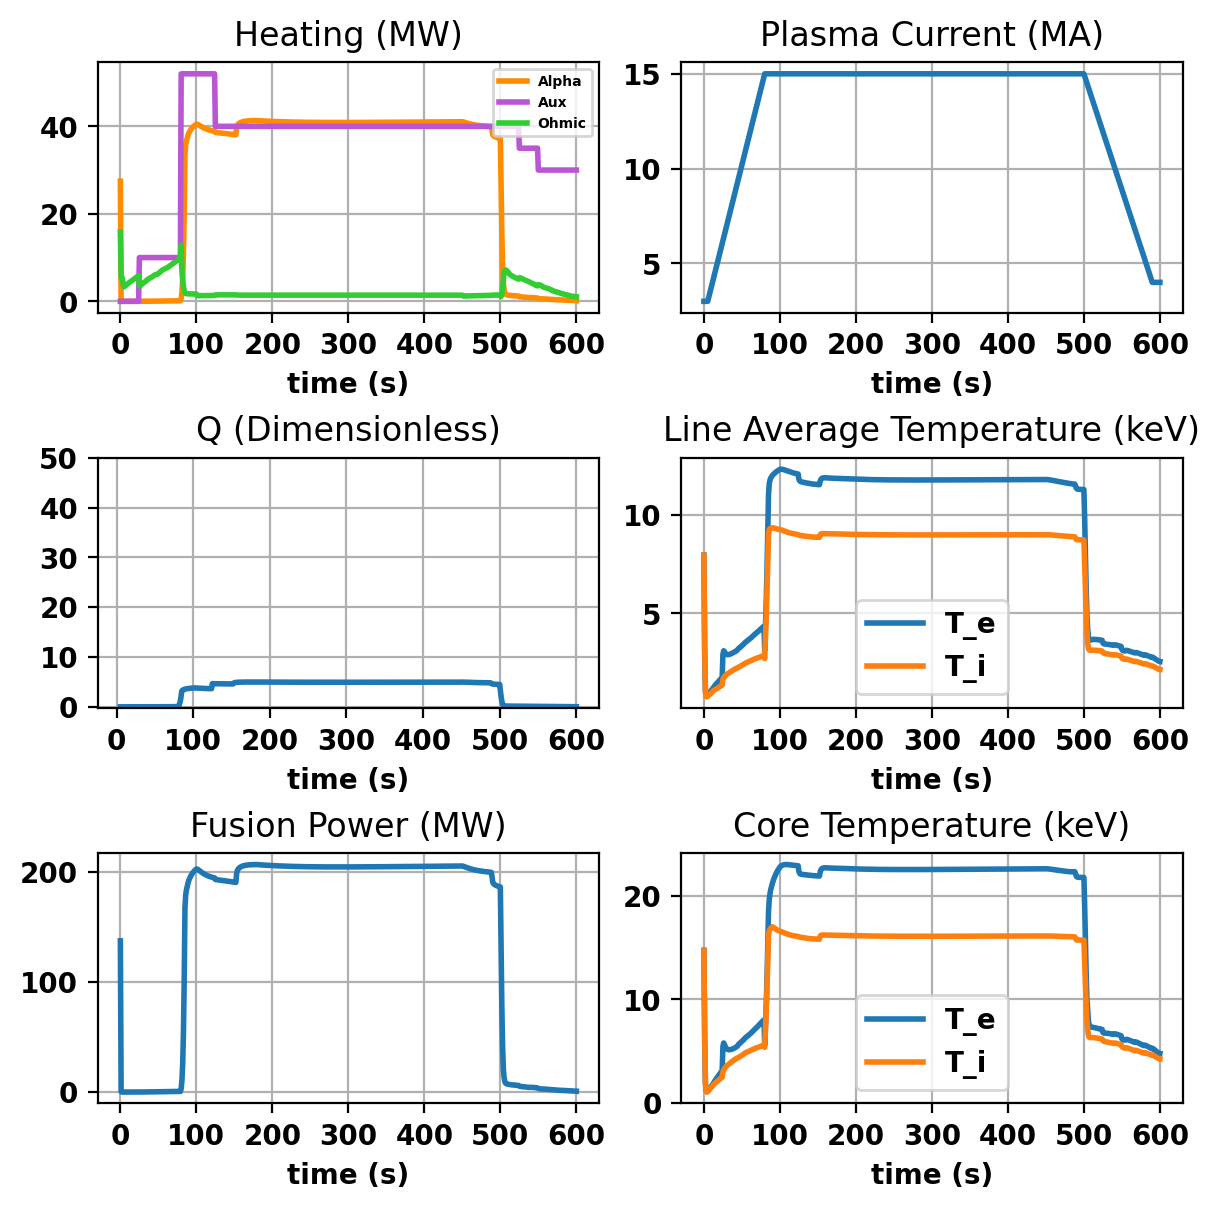

In [7]:
fname = 'res.json'

res = None
with open(fname, 'r') as f:
    res = json.loads(f.read())

fig, ax = plt.subplots(3, 2) #, figsize=(20,10))

ax[0,0].set_title('Heating (MW)')
ax[0,0].plot(res['P_alpha_total']['x'], np.array(res['P_alpha_total']['y']) / 1.0E6, label='Alpha', c='darkorange')
ax[0,0].plot(res['P_aux_total']['x'], np.array(res['P_aux_total']['y']) / 1.0E6, label='Aux', c='mediumorchid')
ax[0,0].plot(res['P_ohmic_e']['x'], np.array(res['P_ohmic_e']['y']) / 1.0E6, label='Ohmic', c='limegreen')
# ax[0,0].plot(res['P_radiation_e']['x'], np.array(res['P_radiation_e']['y']) / 1.0E6, label='P_radiation_e', c='')
ax[0,0].grid(True)
ax[0,0].legend(fontsize=5, loc='upper right')

ax[1,0].set_title('Q (Dimensionless)')
ax[1,0].plot(res['Q']['x'][5:], res['Q']['y'][5:], label='Q')
ax[1,0].set_yticks([0, 10, 20, 30, 40, 50])
ax[1,0].grid(True)

ax[2,0].set_title('Fusion Power (MW)')
ax[2,0].plot(res['P_alpha_total']['x'], 5.0 * np.array(res['P_alpha_total']['y']) / 1.0E6)
ax[2,0].grid(True)

ax[0,1].set_title('Plasma Current (MA)')
ax[0,1].plot(res['Ip']['x'], np.array(res['Ip']['y']) / 1.0E6)
ax[0,1].grid(True)

ax[2,1].set_title('Core Temperature (keV)')
ax[2,1].plot(res['T_e_core']['x'], res['T_e_core']['y'], label='T_e')
ax[2,1].plot(res['T_i_core']['x'], res['T_i_core']['y'], label='T_i')
ax[2,1].grid(True)
ax[2,1].legend()

ax[1,1].set_title('Line Average Temperature (keV)')
ax[1,1].plot(res['T_e_line_avg']['x'], res['T_e_line_avg']['y'], label='T_e')
ax[1,1].plot(res['T_i_line_avg']['x'], res['T_i_line_avg']['y'], label='T_i')
ax[1,1].grid(True)
ax[1,1].legend()

ax[0,0].set_xticks(np.linspace(0, 600, 7))
ax[0,1].set_xticks(np.linspace(0, 600, 7))
ax[1,0].set_xticks(np.linspace(0, 600, 7))
ax[1,1].set_xticks(np.linspace(0, 600, 7))
ax[2,0].set_xticks(np.linspace(0, 600, 7))
ax[2,1].set_xticks(np.linspace(0, 600, 7))

ax[0,0].set_xlabel('time (s)')
ax[1,0].set_xlabel('time (s)')
ax[2,0].set_xlabel('time (s)')
ax[0,1].set_xlabel('time (s)')
ax[1,1].set_xlabel('time (s)')
ax[2,1].set_xlabel('time (s)')

plt.tight_layout(pad=0.5)

plt.show()

## More results

Graph representative density and temperature profiles during ramp-up and flat-top.

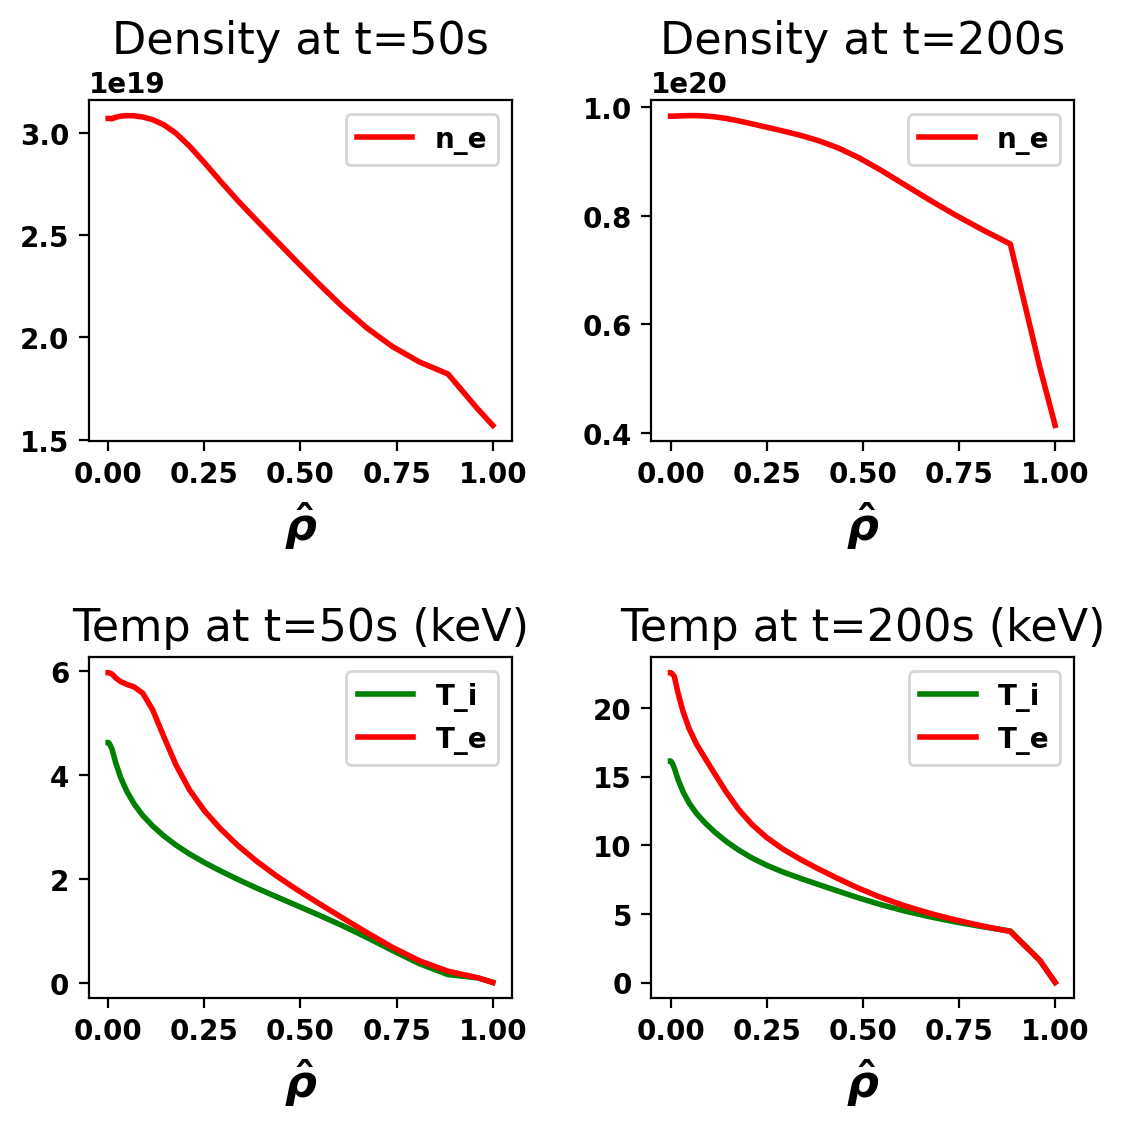

In [8]:
fig, ax = plt.subplots(2, 2)

ax[0,0].set_title('Density at t=50s', fontsize=16)
# ax[0,0].plot(res['n_i_80s']['x'], res['n_i_80s']['y'], label='n_i')
ax[0,0].plot(res['n_e']['50.0']['x'], res['n_e']['50.0']['y'], label='n_e', c='r')
ax[0,0].set_xlabel(r'$\hat{\rho}$', fontsize=16)
ax[0,0].legend()

ax[0,1].set_title('Density at t=200s', fontsize=16)
# ax[0,1].plot(res['n_i_300s']['x'], res['n_i_300s']['y'], label='n_i')
ax[0,1].plot(res['n_e']['200.0']['x'], res['n_e']['200.0']['y'], label='n_e', c='r')
ax[0,1].set_xlabel(r'$\hat{\rho}$', fontsize=16)
ax[0,1].legend()

ax[1,0].set_title('Temp at t=50s (keV)', fontsize=16)
ax[1,0].plot(res['T_i']['50.0']['x'], res['T_i']['50.0']['y'], label='T_i', c='g')
ax[1,0].plot(res['T_e']['50.0']['x'], res['T_e']['50.0']['y'], label='T_e', c='r')
ax[1,0].set_xlabel(r'$\hat{\rho}$', fontsize=16)
ax[1,0].legend()

ax[1,1].set_title('Temp at t=200s (keV)', fontsize=16)
ax[1,1].plot(res['T_i']['200.0']['x'], res['T_i']['200.0']['y'], label='T_i', c='g')
ax[1,1].plot(res['T_e']['200.0']['x'], res['T_e']['200.0']['y'], label='T_e', c='r')
ax[1,1].set_xlabel(r'$\hat{\rho}$', fontsize=16)
ax[1,1].legend()

fig.tight_layout(pad=2.0)
plt.show()

{'CS3U': {'5.0': -15379603.36347753, '13.333333333333334': -16291157.840409582, '21.666666666666668': -15822686.50653737, '30.0': -13944369.174870135, '38.333333333333336': -14261098.200206915, '46.66666666666667': -14744917.34071023, '55.0': -13934999.942809192, '63.333333333333336': -12130994.36128641, '71.66666666666667': -9407560.398113303, '80.0': -4922733.838555881, '100.0': 26890518.972360156, '138.88888888888889': 27469930.645848475, '177.77777777777777': 28260719.66797119, '216.66666666666666': 29113575.745540466, '255.55555555555554': 29987570.475021817, '294.44444444444446': 30845395.27234843, '333.3333333333333': 31726029.75419496, '372.2222222222222': 32604308.850628864, '411.1111111111111': 33479304.199487798, '450.0': 34350882.02274933, '500.0': 10211156.122538647, '511.1111111111111': 7302169.367946457, '522.2222222222222': 8527792.33295433, '533.3333333333334': 10414212.100530872, '544.4444444444445': 11500163.843470907, '555.5555555555555': 12583310.693798568, '566.66

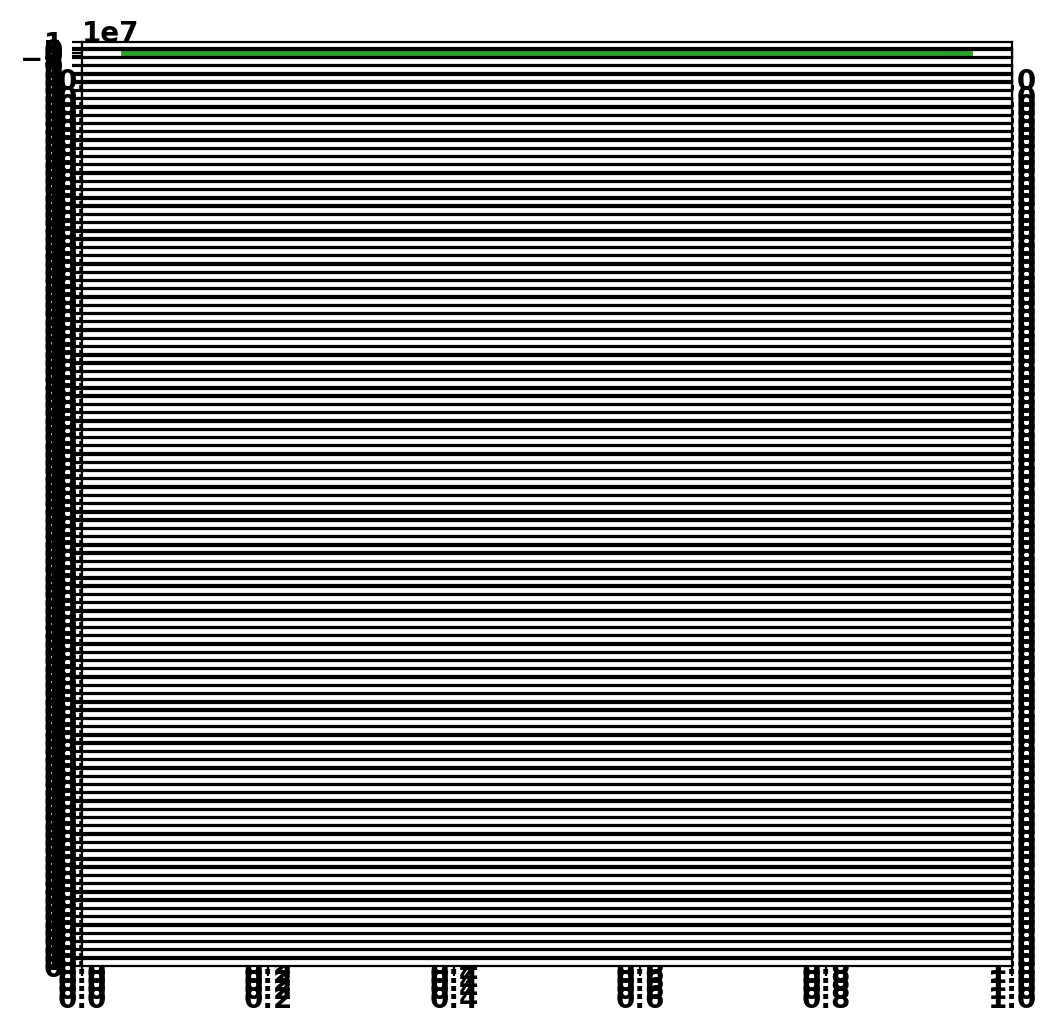

In [ ]:
fig, ax = plt.subplots(1,1)

print(res['COIL'])
times = res['eqtimes']
for coil_name, current_map in res['COIL'].items():
    times = sorted([float(t) for t in res['eqtimes']])
    currents = [float(current_map[str(t)]) for t in times]
    ax[1].plot(times, currents, label=coil_name)

plt.show()